# Customer Churn Prediction

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

#import warnings
#warnings.simplefilter("ignore")

### Data Preparation based on EDA

In [2]:
def datapreparation(filepath):
    
    df = pd.read_csv(filepath)
    df.drop(["customerID"], inplace = True, axis = 1)
    
    df.TotalCharges = df.TotalCharges.replace(" ",np.nan)
    df.TotalCharges.fillna(0, inplace = True)
    df.TotalCharges = df.TotalCharges.astype(float)
    
    cols1 = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn', 'PhoneService']
    for col in cols1:
        df[col] = df[col].apply(lambda x: 0 if x == "No" else 1)
   
    df.gender = df.gender.apply(lambda x: 0 if x == "Male" else 1)
    df.MultipleLines = df.MultipleLines.map({'No phone service': 0, 'No': 0, 'Yes': 1})
    
    cols2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in cols2:
        df[col] = df[col].map({'No internet service': 0, 'No': 0, 'Yes': 1})
    
    df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)
    
    return df

In [3]:
telco = datapreparation(filepath = "./Data/Telco_Customer_Churn.csv")
telco.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,0,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,0,0,0,1,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,0,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,...,42.30,1840.75,0,0,0,1,0,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,70.70,151.65,1,1,0,0,0,0,1,0


In [4]:
telco.isnull().any().any()

False

The dataframe has no null values

### Model building

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [6]:
train, test = train_test_split(telco, test_size=0.2, random_state=111, stratify = telco.Churn)

In [7]:
x = telco.columns[telco.columns!="Churn"]
y = "Churn"
train_x = train[x]
train_y = train[y]
test_x = test[x]
test_y = test[y]

In [8]:
#function for model fitting
def churn_prediction(algo, training_x, training_y, testing_x, testing_y, cols, cf = 'coefficients'):
    algo.fit(training_x,training_y)
    predictions = algo.predict(testing_x)
    probabilities = algo.predict_proba(testing_x)[:,1]
    
    #coeffs
    if cf == "coefficients":
        coefficients = pd.DataFrame(algo.coef_.ravel())
    elif cf == "features":
        coefficients = pd.DataFrame(algo.feature_importances_)
        
    column_df = pd.DataFrame(cols)
    coef_sumry = (pd.merge(coefficients, column_df, left_index= True, right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algo)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,probabilities) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities)
    
    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
    plt.subplot(212)
    sns.barplot(x = coef_sumry["features"] ,y = coef_sumry["coefficients"])
    plt.title('Feature Importances')
    plt.xticks(rotation="vertical")
    
    plt.show()

### Hyperparameter Tuning

#### Grid 1: Selecting class weight and estimators

In [9]:
param_grid1 = {'max_features':['auto', 'sqrt', 'log2', None],
               'n_estimators':[300, 500, 700, 900, 1100, 1300]}

rf_model = RandomForestClassifier()
grid1 = GridSearchCV(estimator=rf_model, param_grid=param_grid1, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid1.fit(train_x, train_y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2', None],
                         'n_estimators': [300, 500, 700, 900, 1100, 1300]},
             scoring='f1', verbose=1)

In [10]:
grid1.best_params_

{'max_features': 'log2', 'n_estimators': 900}

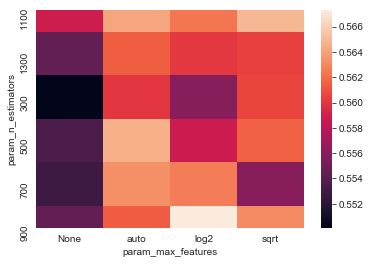

In [11]:
dt = pd.DataFrame(grid1.cv_results_)
dt.param_max_features = dt.param_max_features.astype(str)
dt.param_n_estimators = dt.param_n_estimators.astype(str)

table = pd.pivot_table(dt, values='mean_test_score', index='param_n_estimators', 
                       columns='param_max_features')
     
sns.heatmap(table)

In [12]:
grid1.best_score_

0.5672832766900499

#### Grid 2: Selecting max depth and split criterion

In [13]:
param_grid2 = {'max_features':['log2'],
               'n_estimators':[800, 900, 1000],
               'criterion': ['entropy', 'gini'],
               'max_depth': [7, 9, 11, 13, 15, None]}

rf_model = RandomForestClassifier()
grid2 = GridSearchCV(estimator=rf_model, param_grid=param_grid2, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid2.fit(train_x, train_y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [7, 9, 11, 13, 15, None],
                         'max_features': ['log2'],
                         'n_estimators': [800, 900, 1000]},
             scoring='f1', verbose=1)

In [14]:
grid2.best_params_

{'criterion': 'gini',
 'max_depth': 11,
 'max_features': 'log2',
 'n_estimators': 1000}

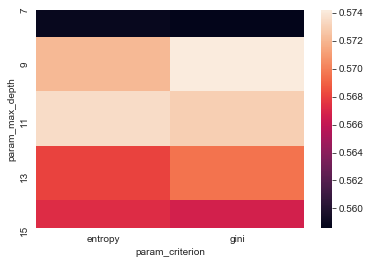

In [15]:
dt = pd.DataFrame(grid2.cv_results_)
table = pd.pivot_table(dt, values='mean_test_score', index='param_max_depth', columns='param_criterion')  
sns.heatmap(table)

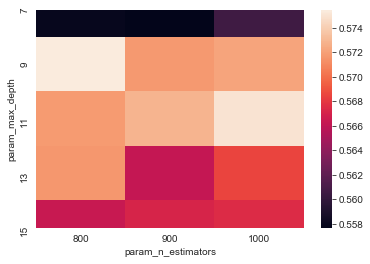

In [16]:
table = pd.pivot_table(dt, values='mean_test_score', index='param_max_depth', columns='param_n_estimators')
sns.heatmap(table)

In [17]:
grid2.best_score_

0.5767927713710824

Checking if other depth and estimator value results better score

In [18]:
param_grid2_2 = {'max_features':['log2'],
                 'n_estimators':[950, 1000, 1050],
                 'criterion': ['gini'],
                 'max_depth': [10, 11, 12]}

rf_model = RandomForestClassifier()
grid2_2 = GridSearchCV(estimator=rf_model, param_grid=param_grid2, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid2_2.fit(train_x, train_y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [7, 9, 11, 13, 15, None],
                         'max_features': ['log2'],
                         'n_estimators': [800, 900, 1000]},
             scoring='f1', verbose=1)

In [19]:
grid2_2.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'log2',
 'n_estimators': 900}

In [20]:
grid2_2.best_score_

0.5765613243686758

#### Grid 3: Selecting minimum samples leaf and split

In [21]:
param_grid3 = {'max_features':['log2'],
               'n_estimators':[1000],
               'criterion': ['gini'],
               'max_depth': [11],
               'min_samples_leaf': [1, 3, 5, 7],
               'min_samples_split': [2, 4, 6, 8]}

rf_model = RandomForestClassifier()
grid3 = GridSearchCV(estimator=rf_model, param_grid=param_grid3, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid3.fit(train_x, train_y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [11],
                         'max_features': ['log2'],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [1000]},
             scoring='f1', verbose=1)

In [22]:
grid3.best_params_

{'criterion': 'gini',
 'max_depth': 11,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

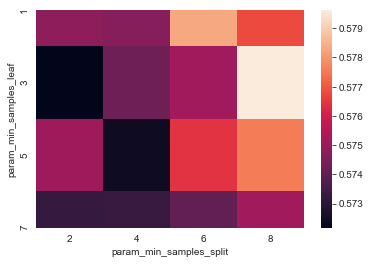

In [23]:
dt = pd.DataFrame(grid3.cv_results_)
table = pd.pivot_table(dt, values='mean_test_score', index='param_min_samples_leaf', columns='param_min_samples_split')  
sns.heatmap(table)

In [24]:
grid3.best_score_

0.5796143536671119

#### Grid 4: Selecting class weight

In [25]:
param_grid4 = {'class_weight':[{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}],
               'max_features':['log2'],
               'n_estimators':[1000],
               'criterion': ['gini'],
               'max_depth': [11],
               'min_samples_leaf': [3],
               'min_samples_split': [8]}

rf_model = RandomForestClassifier()
grid4 = GridSearchCV(estimator=rf_model, param_grid=param_grid4, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid4.fit(train_x, train_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}],
                         'criterion': ['gini'], 'max_depth': [11],
                         'max_features': ['log2'], 'min_samples_leaf': [3],
                         'min_samples_split': [8], 'n_estimators': [1000]},
             scoring='f1', verbose=1)

In [26]:
grid4.best_params_

{'class_weight': {0: 1, 1: 3},
 'criterion': 'gini',
 'max_depth': 11,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

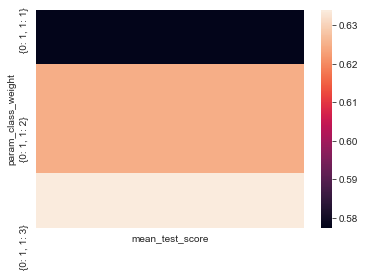

In [27]:
dt = pd.DataFrame(grid4.cv_results_)
dt.param_class_weight = dt.param_class_weight.astype(str)
table = pd.pivot_table(dt, values='mean_test_score', index='param_class_weight')
     
sns.heatmap(table)

In [28]:
grid4.best_score_

0.6338649908469013

#### Final Model

In [29]:
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 3},
                               criterion='gini', max_depth=11, max_features='log2',
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_impurity_split=None,
                               min_samples_leaf=3, min_samples_split=8,
                               min_weight_fraction_leaf=0.0, n_estimators=1000,
                               n_jobs=None, oob_score=False, random_state=None,
                               verbose=0, warm_start=False)

RandomForestClassifier(class_weight={0: 1, 1: 3}, max_depth=11,
                       max_features='log2', min_samples_leaf=3,
                       min_samples_split=8, n_estimators=1000)

 Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.80      0.84      1035
           1       0.56      0.70      0.62       374

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.78      0.78      1409

Accuracy   Score :  0.7750177430801988
Area under curve :  0.8480043400759514 



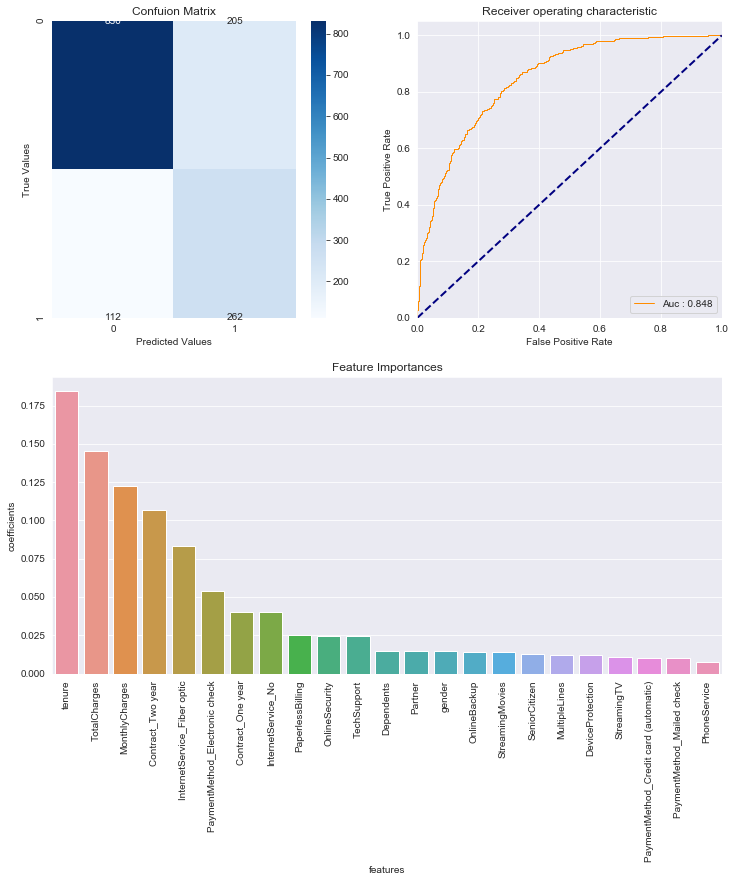

In [30]:
churn_prediction(model, train_x, train_y, test_x, test_y, x,"features")

Checking the model's performance on train data itself

In [31]:
train_scores = cross_val_score(model, train_x, train_y, cv = 5, scoring='f1')
train_scores

array([0.60511364, 0.65878877, 0.62209302, 0.59337349, 0.64927536])

In [32]:
np.mean(train_scores)

0.6257288579834298

As we can see that the performance of the model on test data is same as training data. So, we can conclude that there is no overfitting or underfitting.

#### Saving model

In [33]:
import pickle
pickle.dump(model, open('churnmodel.pkl','wb'))

## Model Interpretability

#### ELI5

In [34]:
import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


In [35]:
perm = PermutationImportance(model, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm, feature_names = test_x.columns.tolist())

Weight,Feature
0.0196 ± 0.0080,InternetService_Fiber optic
0.0055 ± 0.0083,PaymentMethod_Electronic check
0.0054 ± 0.0093,Contract_One year
0.0033 ± 0.0037,InternetService_No
0.0021 ± 0.0043,OnlineSecurity
0.0020 ± 0.0039,TechSupport
0.0011 ± 0.0054,PaperlessBilling
0.0010 ± 0.0090,Contract_Two year
0.0007 ± 0.0016,MultipleLines
0.0001 ± 0.0011,StreamingMovies


Visualizing how the partial dependance plots look for top features

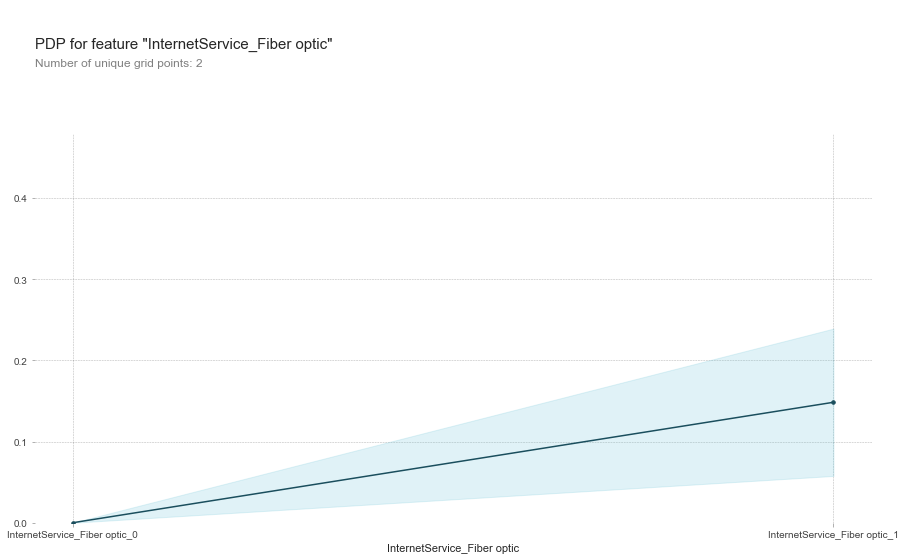

In [36]:
from pdpbox import pdp, info_plots

pdp_p = pdp.pdp_isolate(model=model, dataset=test_x, model_features=test_x.columns.values, 
                        feature='InternetService_Fiber optic')
pdp.pdp_plot(pdp_p, 'InternetService_Fiber optic')
plt.show()

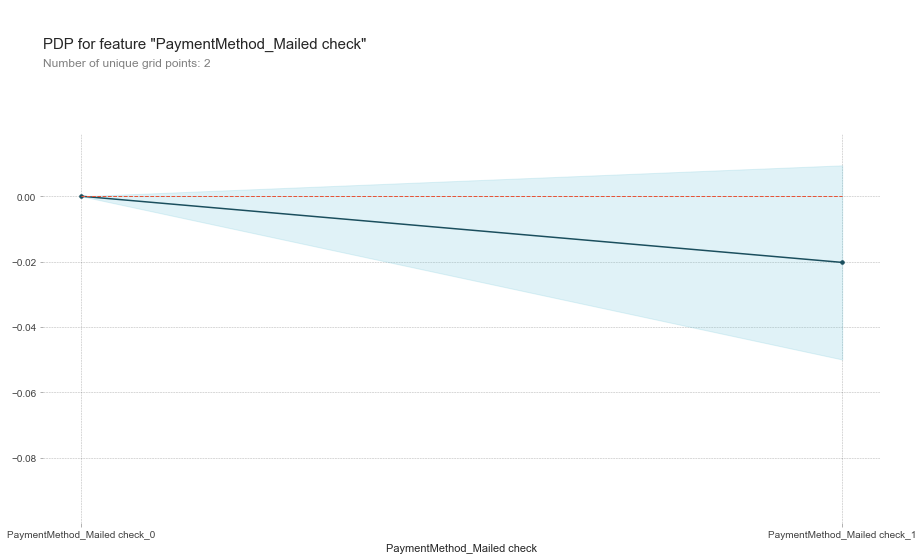

In [37]:
pdp_p = pdp.pdp_isolate(model=model, dataset=test_x, model_features=test_x.columns.values, 
                        feature='PaymentMethod_Mailed check')
pdp.pdp_plot(pdp_p, 'PaymentMethod_Mailed check')
plt.show()

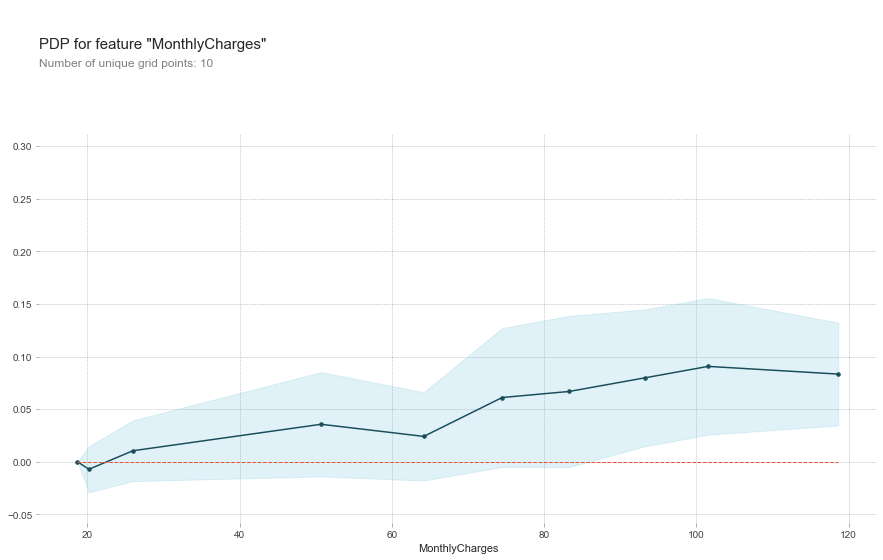

In [38]:
pdp_p = pdp.pdp_isolate(model=model, dataset=test_x, model_features=test_x.columns.values, feature='MonthlyCharges')
pdp.pdp_plot(pdp_p, 'MonthlyCharges')
plt.show()

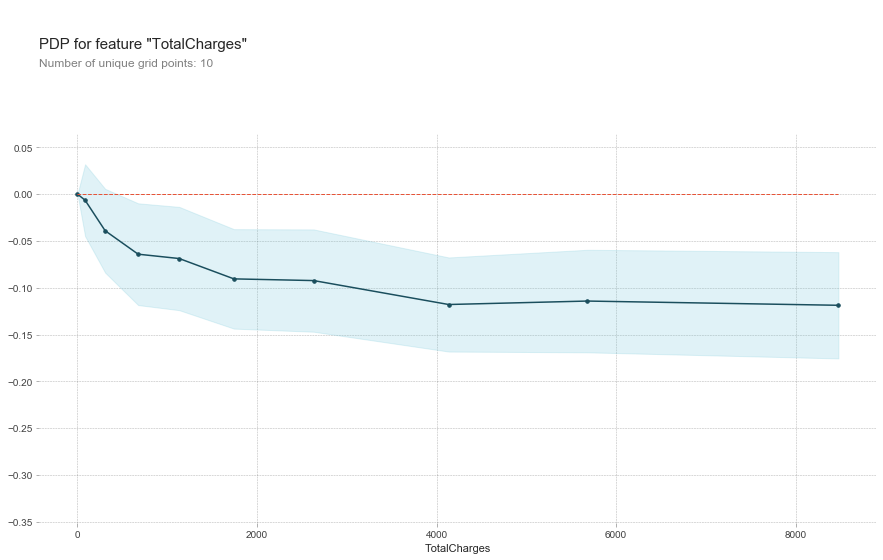

In [39]:
pdp_p = pdp.pdp_isolate(model=model, dataset=test_x, model_features=test_x.columns.values, feature='TotalCharges')
pdp.pdp_plot(pdp_p, 'TotalCharges')
plt.show()

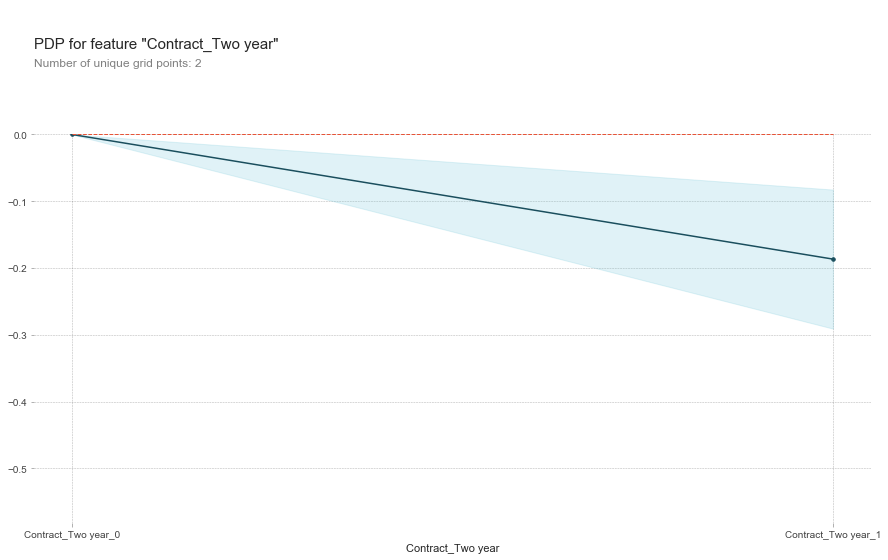

In [40]:
pdp_p = pdp.pdp_isolate(model=model, dataset=test_x, model_features=test_x.columns.values, 
                        feature='Contract_Two year')
pdp.pdp_plot(pdp_p, 'Contract_Two year')
plt.show()

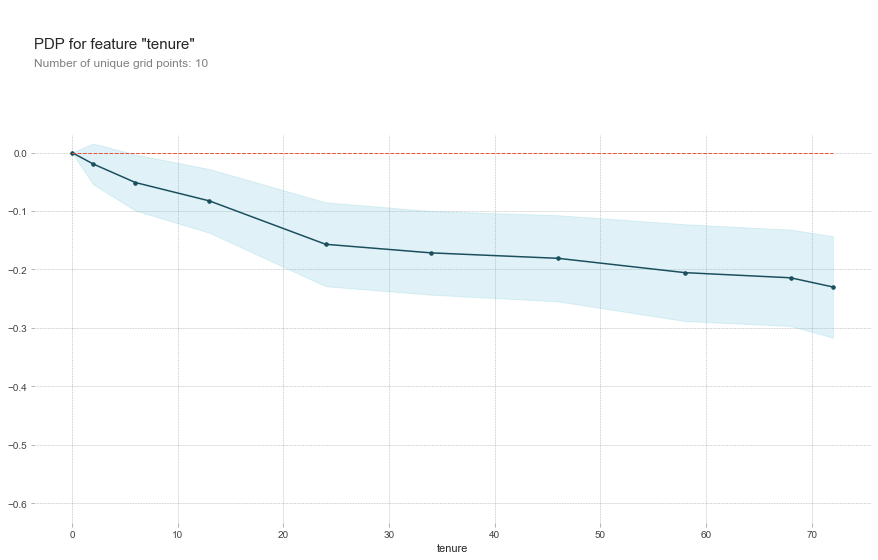

In [41]:
pdp_p = pdp.pdp_isolate(model=model, dataset=test_x, model_features=test_x.columns.values, 
                        feature='tenure')
pdp.pdp_plot(pdp_p, 'tenure')
plt.show()

#### SHAP

In [42]:
import shap 
shap.initjs()

import joblib

In [43]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(np.array(test_x.iloc[0]))
shap.force_plot(explainer.expected_value[1], shap_values[1], test_x.iloc[0])

In [44]:
# Saving Explainer
ex_filename = 'explainer.bz2'
joblib.dump(explainer, filename=ex_filename, compress=('bz2', 9))

['explainer.bz2']

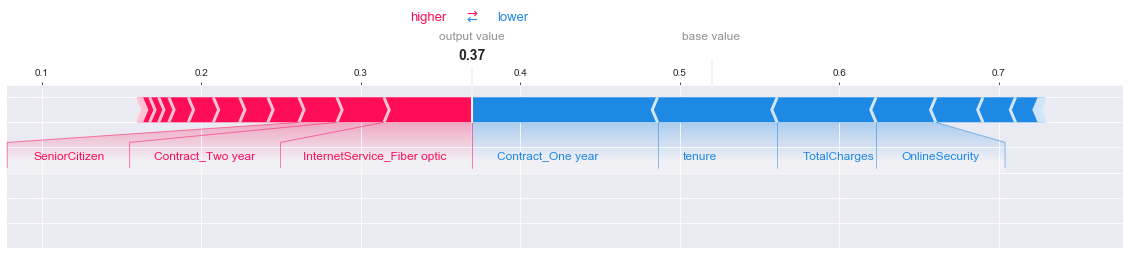

In [46]:
explainer = joblib.load(filename="explainer.bz2")
shap_values = explainer.shap_values(np.array(test_x.iloc[0]))
shap.force_plot(explainer.expected_value[1], shap_values[1], list(test_x.columns), matplotlib = True, show = False).savefig('static/images/shap.png', bbox_inches="tight")

#### Gauge Chart

In [50]:
from matplotlib.patches import Circle, Wedge, Rectangle

def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

def gauge(labels=['LOW','MEDIUM','HIGH','EXTREME'], \
          colors=['#00FF00','#FFFF00','#FF7700','#FF0000'], Probability=1, fname=False): 
    
    N = len(labels)
    colors = colors[::-1]

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(4)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, 'Churn Probability ' + np.round(Probability,2).astype(str), horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = (1-Probability)*180
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)

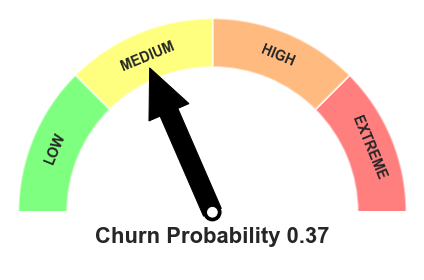

In [51]:
gauge(Probability=model.predict_proba(test_x.iloc[0:1])[0,1])

In [49]:
# final features
test_x.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')